In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os

# Унифицируем некоторые описания неисправностей

In [39]:
messages = pd.read_excel('../data/raw/messages.xlsx')
messages['target'] = 'Y_' + messages['ИМЯ_МАШИНЫ'] + '_' + messages['НАЗВАНИЕ_ТЕХ_МЕСТА']

In [40]:
messages['ОПИСАНИЕ'].value_counts().head(10)

ОПИСАНИЕ
утечка масла               56
Утечка масла.              38
течь масла                 36
просос                     24
Утечка масла               17
износ щеток                11
Течь масла                 10
Дефект подшипников.         7
Абразивный износ ротора     7
Прососы                     7
Name: count, dtype: int64

In [61]:
messages = messages.replace({
    'Утечка масла.': 'утечка масла',
    'течь масла': 'утечка масла',
    'Утечка масла': 'утечка масла',
    'Течь масла': 'утечка масла',
    'Течь масла': 'утечка масла',
    'Подтекает масло': 'утечка масла',
    'Подтекает масло.': 'утечка масла',
    'течет масло': 'утечка масла',
    'Прососы': 'просос',
    'Просос': 'просос',
    'Прососы.': 'просос',
    'прососы': 'просос',
    'Прососы по разъёму': 'просос',
    'просос большая загазованность': 'просос',
    'нет нигрола': 'утечка нигрола',
    'Долить нигрол': 'утечка нигрола',
    'сильная утечка нигрола из редуктора': 'утечка нигрола',
    'Отсутствует нигрол': 'утечка нигрола',
    'сильная утечка нигрола': 'утечка нигрола',
    'Долить нигрол. Щуп сухой.': 'утечка нигрола',
    'изношены щетки': 'износ щеток',
    
})

In [62]:
# descr = messages['ОПИСАНИЕ'].values
# for el in descr:
#     if 'показаний' in el:
#         print(el)

In [63]:
# messages[messages['ОПИСАНИЕ'].str.contains('показаний')]

In [64]:
messages['ОПИСАНИЕ'].value_counts().head(20)

ОПИСАНИЕ
утечка масла                            163
просос                                   47
износ щеток                              15
утечка нигрола                           14
Абразивный износ ротора                   7
Дефект подшипников.                       7
износ подшипников, обмотки статора        6
утечка                                    6
искрение щеток                            6
нагрев подшипника                         5
износ уплотнения разъема улиты            5
остановка эк-ра №8 (вибрация в т.3)       5
остановка эк-ра №5 (2РУ МТЗ)              4
остановка эксг. №5 (температура т.1)      4
остановка эк-ра №5 (вибрация в т.1)       4
выброс CO                                 4
клинит                                    4
нет смазки                                4
Низкий уровень масла                      4
Коррозионный износ патрубка               4
Name: count, dtype: int64

Text(0.5, 1.0, 'Количество записей')

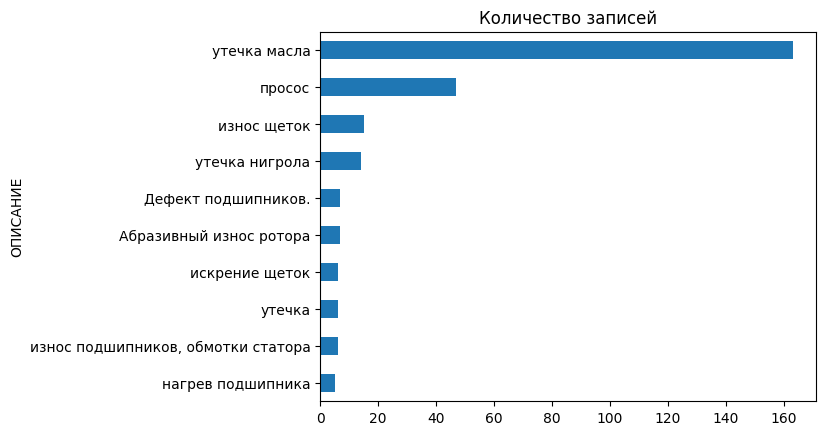

In [65]:
messages['ОПИСАНИЕ'].value_counts()[:10].sort_values().plot(kind='barh')
plt.title('Количество записей')


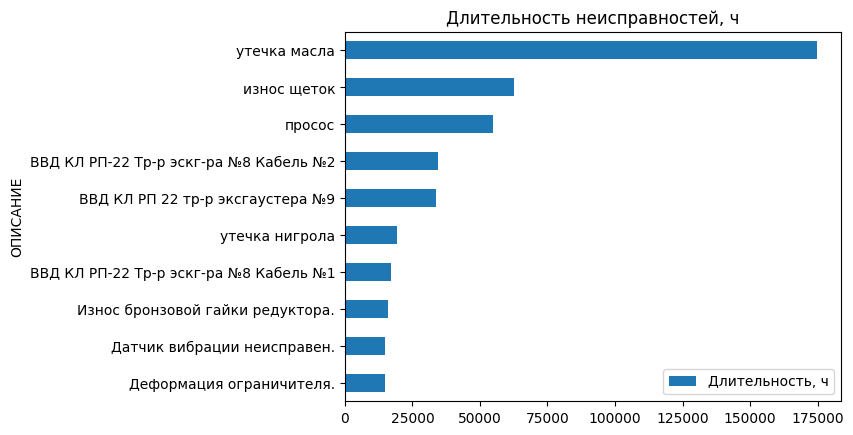

In [66]:
messages.loc[messages['Длительность, ч']<0, 'Длительность, ч'] = 0
messages[['ОПИСАНИЕ','Длительность, ч']].groupby('ОПИСАНИЕ').sum().sort_values('Длительность, ч')[-10:].plot(kind='barh')
plt.title('Длительность неисправностей, ч');

/Users/ivan/Library/Python/3.8/lib/python/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot: xlabel='Длительность, ч'>

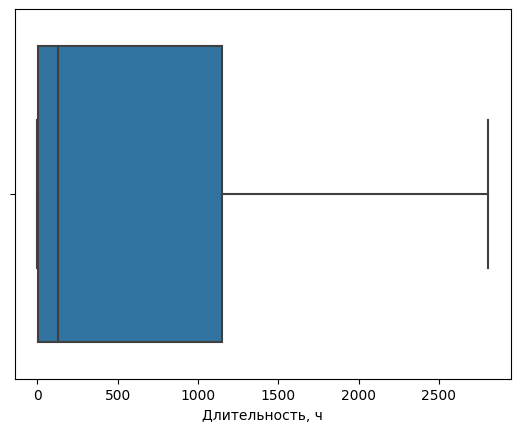

In [69]:
import seaborn as sns
sns.boxplot(messages['Длительность, ч'], showfliers = False)
# .hist(bins)

<AxesSubplot: >

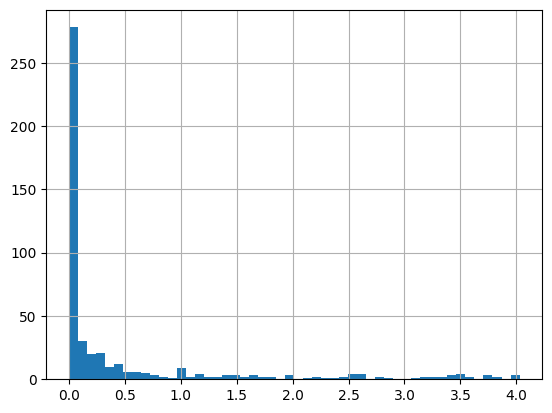

In [80]:
(messages.loc[messages['Длительность, ч']<100, 'Длительность, ч']/24).hist(bins=50)

In [85]:
(messages['Длительность, ч']<=1).sum(), (messages['Длительность, ч']>1).sum()

(249, 732)

# Исправление разметки M3

Выполним переразметку данных по файлу messages.xlsx с удалением неисправностей, в которых не отмечена дата устранения.

In [9]:
y_train = pd.read_parquet('../data/raw/y_train.parquet')
y_train = y_train.astype(np.int8)

In [10]:
if not os.path.exists('../data/processed'):
    os.mkdir('../data/processed')

In [11]:
if os.path.exists('../data/processed/y_train_fixed_M3.parquet'):
    y_train_zero = pd.read_parquet('../data/processed/y_train_fixed_M3.parquet')
    
else:
    y_train = pd.read_parquet('../data/raw/y_train.parquet')
   
    y_train_zero = y_train.replace({2:0, 1:0})
    
    for row in messages[messages['ВИД_СООБЩЕНИЯ']=='M3'].iterrows():
        if row[1]['target'] in y_train_zero.columns:
            if not pd.isnull(row[1]['ДАТА_УСТРАНЕНИЯ_НЕИСПРАВНОСТИ']):
                y_train_zero.loc[(y_train_zero[row[1]['target']]==0)&(y_train_zero.index>=row[1]['ДАТА_НАЧАЛА_НЕИСПРАВНОСТИ'])&(y_train_zero.index<=row[1]['ДАТА_УСТРАНЕНИЯ_НЕИСПРАВНОСТИ']), row[1]['target']] = 2
                # y_train_zero.to_parquet('../datasets/processed/y_train_fixed_mes.parquet.gzip', compression='gzip')
    y_train_zero.to_parquet('../data/processed/y_train_fixed_M3.parquet')

In [19]:
def plot_example_target(colname):
    y_train_zero[colname].resample('1D').max().plot(label='without NaT')
    y_train[colname].resample('1D').max().plot(label='with NaT')

    starts = messages[messages['target']==colname]['ДАТА_НАЧАЛА_НЕИСПРАВНОСТИ']
    ends = messages[messages['target']==colname]['ДАТА_УСТРАНЕНИЯ_НЕИСПРАВНОСТИ']
    indx = messages[messages['target']==colname].index
    for s, e, ind in zip(starts, ends, indx):
        if not pd.isnull(e):
            plt.axvspan(s,e, alpha=0.3, 
                        label=messages.loc[ind]['ОПИСАНИЕ'] + ' (' + messages.loc[ind]['ДАТА_НАЧАЛА_НЕИСПРАВНОСТИ'].__str__() +' '+ messages.loc[ind]['ДАТА_УСТРАНЕНИЯ_НЕИСПРАВНОСТИ'].__str__()+ ')' , 
                        color=list(np.random.choice(range(256), size=3)/255))
    plt.title(colname)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=1)

## Визуализация разметки M3

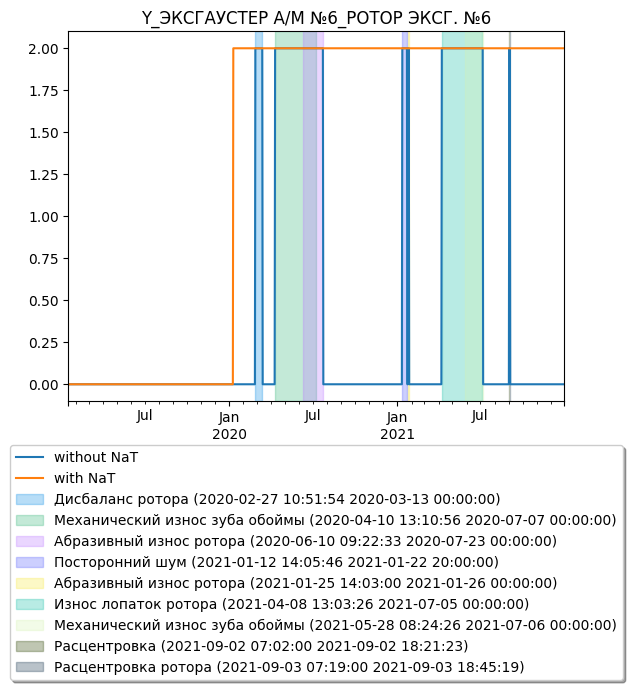

In [20]:
colname = y_train.columns[-17]
plot_example_target(colname)


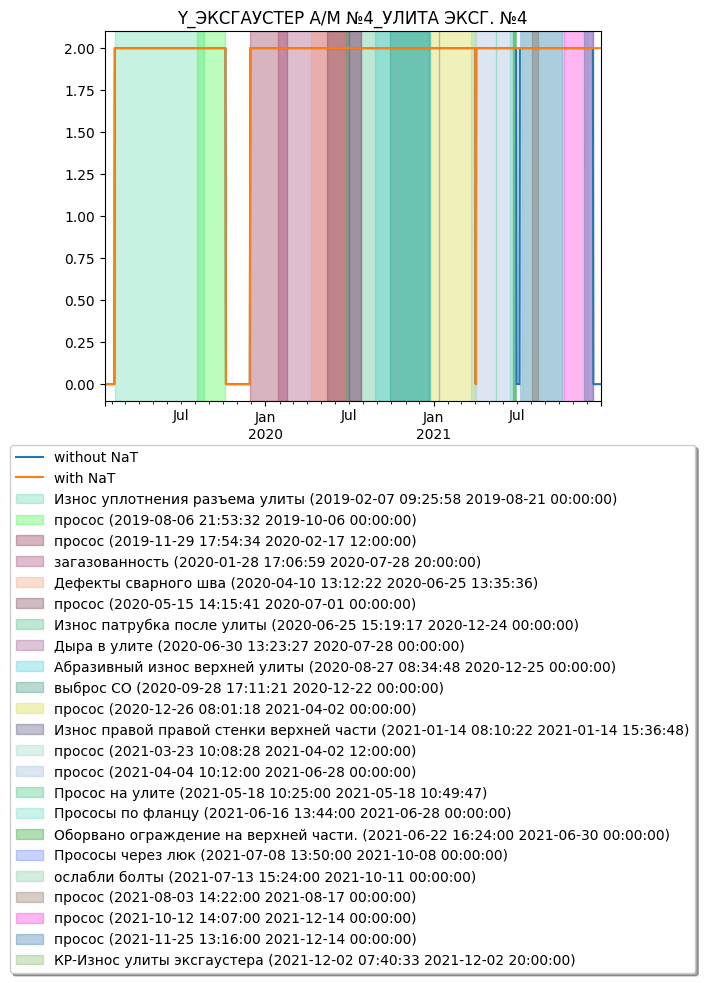

In [21]:
colname = 'Y_ЭКСГАУСТЕР А/М №4_УЛИТА ЭКСГ. №4'
plot_example_target(colname)


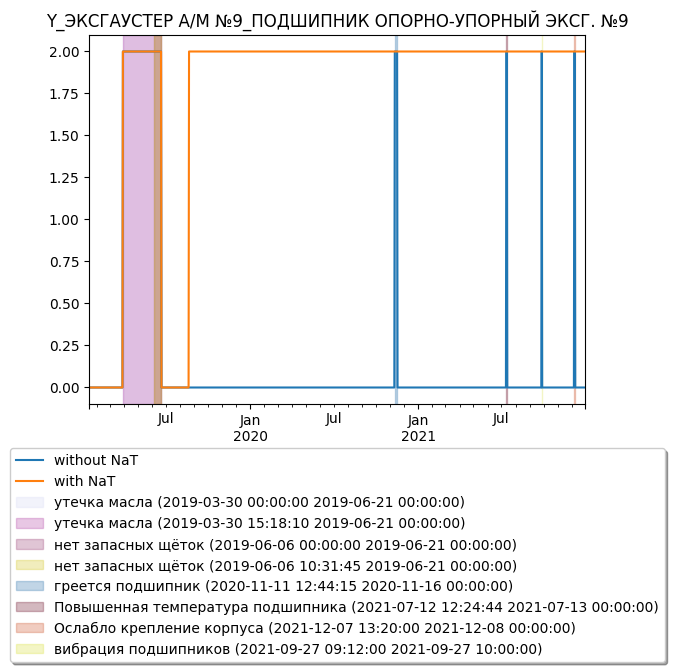

In [22]:
colname = 'Y_ЭКСГАУСТЕР А/М №9_ПОДШИПНИК ОПОРНО-УПОРНЫЙ ЭКСГ. №9'
plot_example_target(colname)




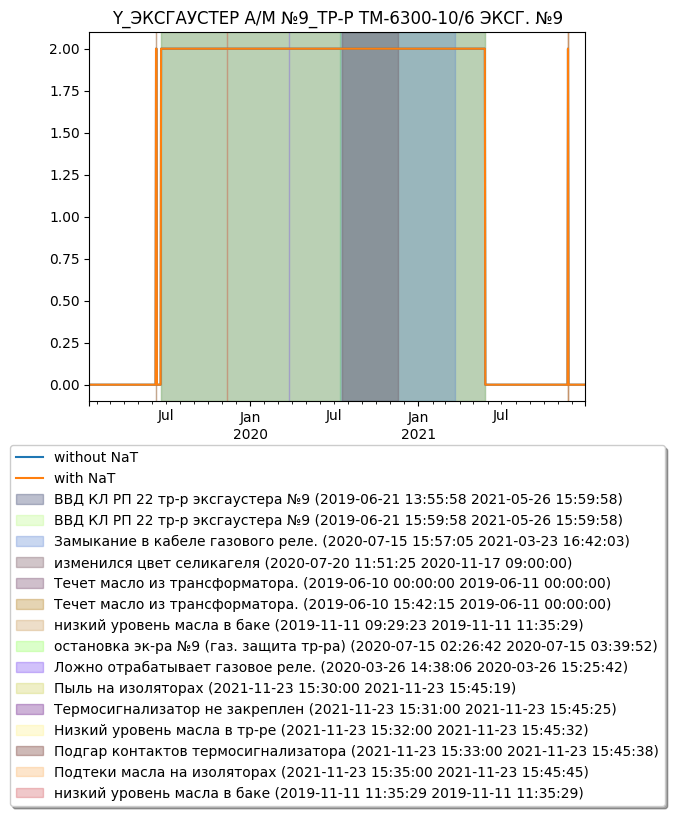

In [23]:
colname = 'Y_ЭКСГАУСТЕР А/М №9_ТР-Р ТМ-6300-10/6 ЭКСГ. №9'
plot_example_target(colname)


In [24]:
# M1 = 0
# M3 = 0
# for col in y_r.columns:
#     un = y_r[col].unique()
#     if 1 in un:
#         M1 += 1
#     print(col, y_r[col].unique())

Text(0.5, 1.0, 'ВРЕМЯ_НАЧАЛА_НЕИСПРАВНОСТИ')

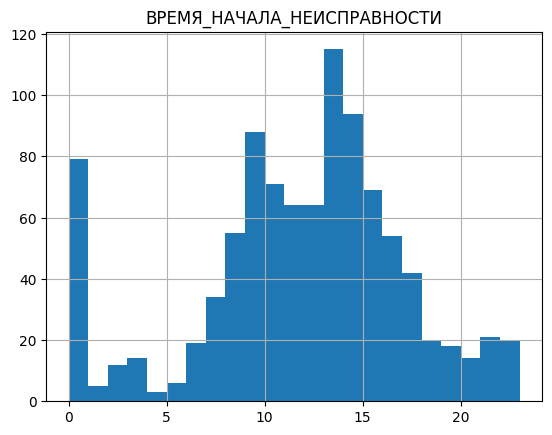

In [24]:
messages['ДАТА_НАЧАЛА_НЕИСПРАВНОСТИ'].dt.hour.hist(bins=23)
plt.title('ВРЕМЯ_НАЧАЛА_НЕИСПРАВНОСТИ')

Text(0.5, 1.0, 'ВРЕМЯ_УСТРАНЕНИЯ_НЕИСПРАВНОСТИ')

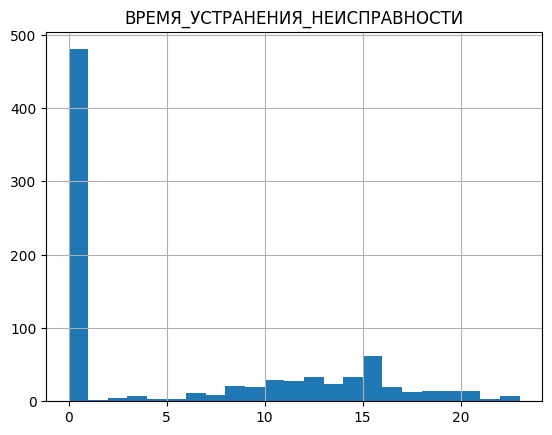

In [26]:
messages['ДАТА_УСТРАНЕНИЯ_НЕИСПРАВНОСТИ'].dt.hour.hist(bins=23)
plt.title('ВРЕМЯ_УСТРАНЕНИЯ_НЕИСПРАВНОСТИ')

In [38]:
(messages['ДАТА_УСТРАНЕНИЯ_НЕИСПРАВНОСТИ'].dt.hour==0).sum()

480

<AxesSubplot: xlabel='ДАТА_НАЧАЛА_НЕИСПРАВНОСТИ'>

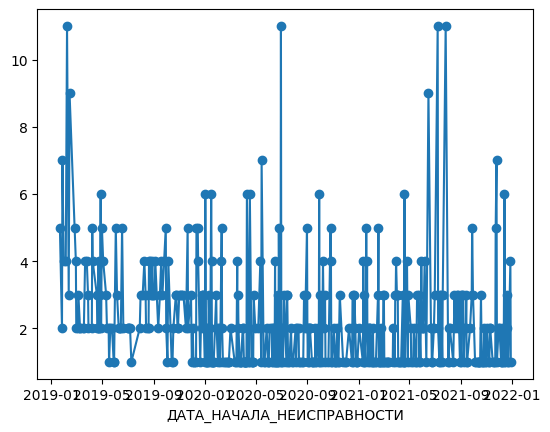

In [35]:
messages.groupby(messages['ДАТА_НАЧАЛА_НЕИСПРАВНОСТИ'].dt.date).count()['target'].plot(marker='o')

In [4]:
# Очистка данных

In [1]:
# for col in [s for s in X_train.columns if 'ТЕМПЕРАТУРА' in s]:
#     X_train[X_train[col]<0] = np.NaN 
#     X_train[X_train[col]>100] = np.NaN

In [ ]:
## Замена отрицательных вибраций на 0

In [2]:
# X_train[[s for s in X_train.columns if 'ТЕМПЕРАТУРА' in s]].describe()

In [3]:
# X_train['ЭКСГАУСТЕР 4. ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 1'].resample('1D').max().plot()